# GluonTS

In [1]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))
import pandas
print('pandas: {}'.format(pandas.__version__))
import numpy
print('numpy: {}'.format(numpy.__version__))
import seaborn
print('seaborn: {}'.format(seaborn.__version__))

matplotlib: 3.2.2
pandas: 1.0.5
numpy: 1.16.6
seaborn: 0.11.1


In [2]:
import mxnet as mx
mx.context.num_gpus()

1

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

import gluonts 
from sklearn.metrics import mean_absolute_error

import warnings                                  
warnings.filterwarnings('ignore')

sns.set()
%matplotlib inline

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
source = pd.read_csv('E:\\Analytics\\Projects\\forecast_cargo_flow\\data\\sample_csu_since_2019.csv', delimiter=';')

In [7]:
df = source[['r_date', 'fact']] # оставляем только дату и факт
df = df.groupby('r_date').sum() # группируем по дате
df.reset_index(inplace=True) # сбрасываем индексы

df['r_date'] = pd.to_datetime(df['r_date'], format='%Y-%m-%d') # r_date в дату
df['fact'] = pd.to_numeric(df['fact']) # факт в числовой тип

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814 entries, 0 to 813
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   r_date  814 non-null    datetime64[ns]
 1   fact    814 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 12.8 KB


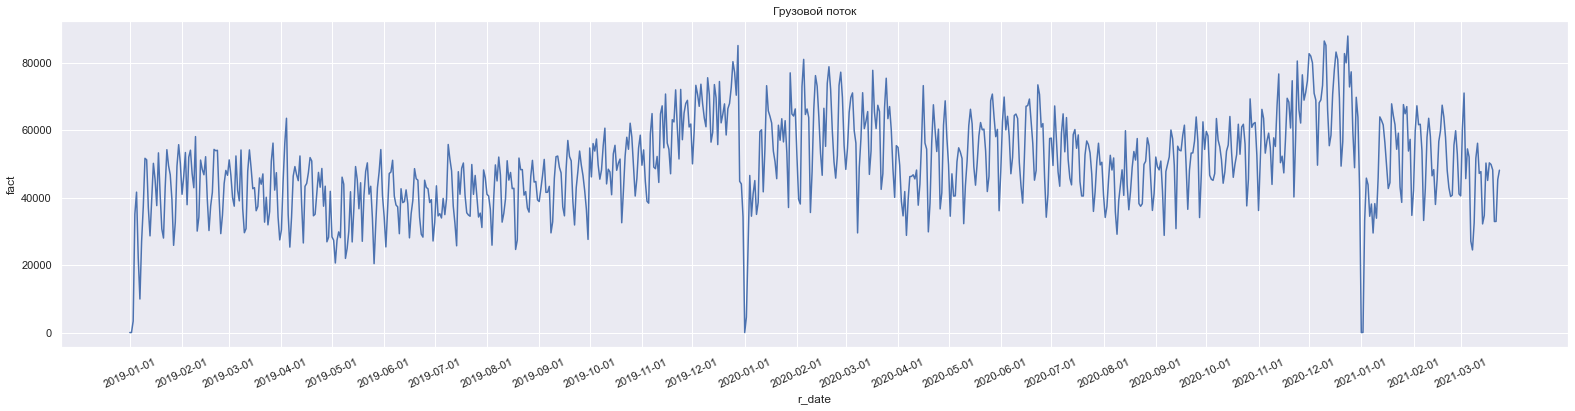

In [9]:
months = df['r_date'].dt.strftime("%Y-%m-01").unique().tolist()
months = pd.to_datetime(months, format='%Y-%m-%d')

plt.figure(figsize=(27, 6))
sns.lineplot(data=df, x="r_date", y="fact")
plt.xticks(months, rotation=25)
plt.title('Грузовой поток')
plt.show()

In [10]:
df.set_index(['r_date'], inplace=True)
df.index = pd.to_datetime(df.index)

In [11]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset([{"start": df.index[0], "target": df.fact[:"2021-03-01"]}], freq = "D")

In [12]:
training_data.list_data

[{'start': Timestamp('2019-01-01 00:00:00'),
  'target': r_date
  2019-01-01        0
  2019-01-02        2
  2019-01-03     3391
  2019-01-04    35128
  2019-01-05    41658
                ...  
  2021-02-25    55624
  2021-02-26    59869
  2021-02-27    52931
  2021-02-28    41126
  2021-03-01    40545
  Name: fact, Length: 791, dtype: int64}]

In [15]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    freq="D", 
    prediction_length=90, 
    trainer=Trainer(epochs=200)
)
predictor = estimator.train(training_data=training_data)

100%|██████████| 50/50 [00:06<00:00,  8.17it/s, epoch=200/200, avg_epoch_loss=8.7]


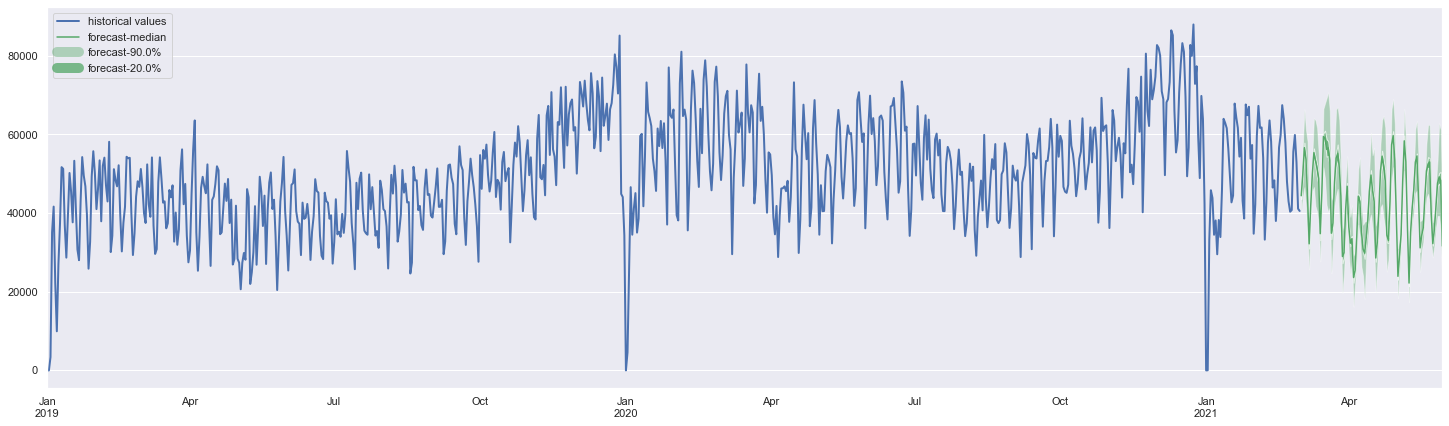

In [18]:
from gluonts.dataset.util import to_pandas

test_data = ListDataset(
    [{"start": df.index[0], "target": df.fact[:"2021-03-01"]}],
    freq = "D"
)

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry).plot(linewidth=2, figsize=(25, 7), label="historical values")
    forecast.plot(color='g', prediction_intervals=[20.0, 90.0], label="forecast")
    
plt.legend(loc='upper left')
plt.grid(axis='x')